# <a id='toc1_'></a>[News Unified Classification V3](#toc0_)



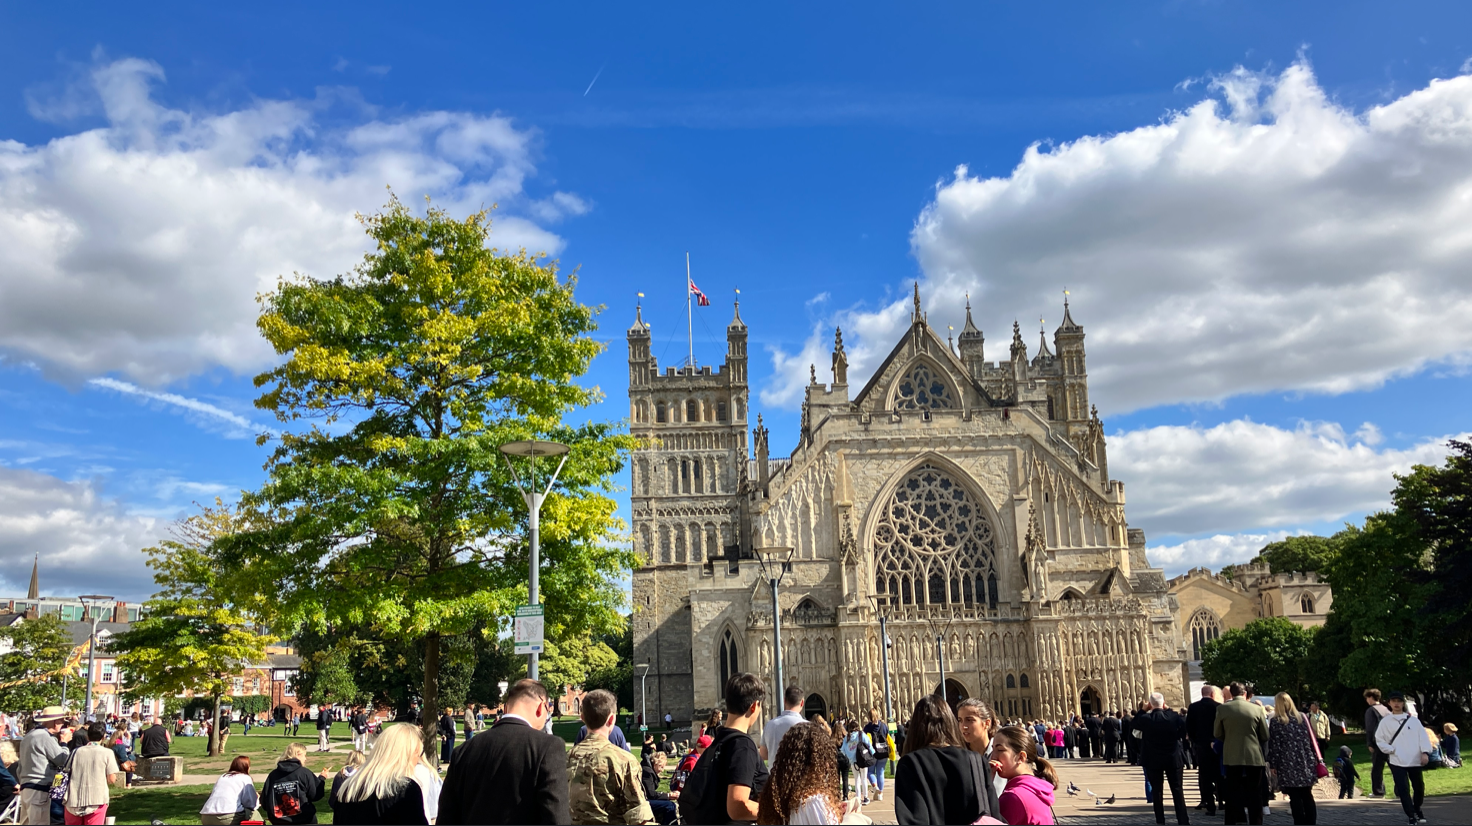

**Table of contents**<a id='toc0_'></a>    
- [News Unified Classification V3](#toc1_)    
- [Problem Definition](#toc2_)    
- [Import Libraries](#toc3_)    
- [Load News Data](#toc4_)    
- [Process Data](#toc5_)    
- [Load Pretrained Model](#toc6_)    
- [7 Implementation on new news data](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Problem Definition](#toc0_)

This notebook demonstrate how to implement a pretrained model to classify news topics.

# <a id='toc3_'></a>[Import Libraries](#toc0_)

In [4]:
from pathlib import Path
import pandas as pd
import gzip
from urllib.request import urlretrieve
from tqdm import tqdm
from tqdm.notebook import tqdm
import os
import numpy as np
# if you are using the fastAI environment, all of these imports work
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer,MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix, \
      accuracy_score,roc_curve, roc_auc_score,auc
            #plot_confusion_matrix,plot_roc_curve, 


# Machine learning models 
from sklearn.linear_model import LogisticRegression as LGR
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import ExtraTreesClassifier as XTC
from sklearn.neural_network import MLPClassifier as MLP

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import plotly
import plotly.express as px
import plotly.graph_objects as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.offline as py
py.init_notebook_mode()
import cufflinks
import datetime
# from multiprocessing import Pool, cpu_count
import os
from time import time

from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
# colab plot display
import plotly.io as pio
# pio.renderers.default = 'colab'

In [7]:
%%capture

%load_ext watermark
%watermark -a "Jason Lu" -u -d -p numpy,pandas,scipy,gensim,plotly,spacy,tensorflow,xgboost,lightgbm

Untiltiies Functions

* `Accuracy()` is to calculate model accuracy

In [8]:
def Accuracy(fitted_clf):
    pred = fitted_clf.predict(X_test)
    acc= accuracy_score(y_test, pred ).round(4)
    return acc

* `Classification_Report()` is to generate classification report in a dataframe

In [10]:
def Classification_Report(y_test, y_pred):
    n=len(y_test.unique())
    report = [ classification_report(y_test, y_pred).split('\n')[i] for i in range(n+7) if len(classification_report(y_test,y_pred).split('\n')[i]) !=0 ]

    df_report = pd.DataFrame()
    for i in range(n+1):
      l = pd.DataFrame(report[i].split())
      df_report = pd.concat([df_report, l ],axis=1, ignore_index=True)

    df_report2 = pd.DataFrame()
    for i in [-1,-2]:
      s = []
      d = []
      for j in report[i].split():
          if j.isalpha():
            s.append(j)

          else:
            d.append(j)

      l = pd.DataFrame([" ".join([str(k) for k in s])] + d).T

      df_report2 = pd.concat([df_report2, l ])

    temp = pd.concat([df_report.T, df_report2],ignore_index=True)
    col = [i for i in temp.iloc[:1,:].values[0] if type(i)==str]
    temp.set_index(0,inplace=True)
    temp.columns = col
    temp = temp.iloc[1:,:]
    temp = temp.reset_index()
    cr = temp.rename(columns={0:'class'})

    return cr

In [11]:
def Multiple_ROC_Curve(X_test, y_test, fitted_model, chart_title:str):
    # This function is to plot ROC Curce

    y_scores = fitted_model.predict_proba(X_test)
    # One hot encode the labels in order to plot them
    y_onehot = pd.get_dummies(y_test, columns=fitted_model.classes_)
    
    # Create an empty figure, and iteratively add new lines
    # every time we compute a new class
    fig = go.Figure()
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1)

    for i in range(y_scores.shape[1]):
        y_true = y_onehot.iloc[:, i]
        y_score = y_scores[:, i]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)

        name = f"{y_onehot.columns[i]} (AUC={auc_score:.3f})"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

    fig.update_layout(
        title = '{title}'.format(title=chart_title),
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis=dict(constrain='domain'),
        width=700, height=600)
    fig.show()

In [13]:
import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from tqdm.notebook import tqdm
tqdm.pandas()

def Preprocessing_Clf_SA(text:str):

    """
    This funtion is to clean news articles for unified classifier and sentiment strength calculator.
    input: text in string
    output: cleaned text by removing manually identified phrases, punctuations, stopwords, lemmas and then convert to lower cases
    
    """

    lemmatizer = WordNetLemmatizer()

    text = text[:999999]
    # manuanlly identified non informative words
    non_informative_word =['copyright',"All rights reserved","Twitter at","Getty",\
        "Our Standards: The Thomson Reuters Trust Principles",\
        "Register now for FREE unlimited access to"] 

    for i in non_informative_word:
        text = text.replace("{i}".format(i=i)," ") 

    tokens = text.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]

    # lemma = [lemmatizer.lemmatize("{tok}".format(tok=tok),get_wordnet_pos(tok)) for tok in tokens ]
    lemma = [lemmatizer.lemmatize("{tok}".format(tok=tok)) for tok in tokens ]
    
    words = " ".join(lemma).lower()

    return words

[nltk_data] Downloading package punkt to /Users/jason/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jason/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jason/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/jason/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# <a id='toc4_'></a>[Load News Data](#toc0_)

Class code and topic name

|class|name|
|--|--|
|0|non-GPR|
|1|Conflict|
|2|Terror Threat|
|3|Corruption|
|4|Social|
|5|Governance|
|6|~~Water~~|
|7|~~Land~~|
|8|~~Air~~|
|9|Foreign Policy|
|10|Environment|

Class 6, 7, 8 is excluded

download data from https://drive.google.com/file/d/1oAxSyq1T9ZEpaoeBzzfzsXelYph-7IX6/view?usp=share_link

In [16]:
data = pd.read_csv('/News_NLP/data/topics_for_classifier_V2.csv',index_col=0)

In [17]:
data.reset_index(drop=True, inplace=True)

# <a id='toc5_'></a>[Process Data](#toc0_)

In [18]:
%%time
data['TDC'] = data['title_description_content'].progress_apply(lambda x: Preprocessing_Clf_SA(x))

  0%|          | 0/5592 [00:00<?, ?it/s]

CPU times: user 8.24 s, sys: 240 ms, total: 8.48 s
Wall time: 8.87 s


Features: TDC

Label: target

In [19]:
data.groupby(['target'])['content'].count()

target
0     741
1     795
2     698
3     793
4     566
5     607
9     609
10    783
Name: content, dtype: int64

Split training and testing set

In [20]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(data, test_size = 0.2,random_state = 42)

In [21]:
X_train, y_train = df_train['TDC'], df_train['target']
X_test, y_test = df_test['TDC'], df_test['target']

In [22]:
# to identify max_features such that accuracy is highest

acc = []
n_features = []

clf = LGR(max_iter=10000,solver= 'saga',random_state=42,n_jobs=-1)

for n in tqdm(range(100,10000,100)):

    vectorizer = TfidfVectorizer(max_features=n)
    # tokenize and build vocabularies
    vectorizer_idf= vectorizer.fit(df_train['TDC'])
    X_train  = vectorizer_idf.transform(df_train['TDC']).toarray()
    X_test  = vectorizer_idf.transform(df_test['TDC']).toarray()
    X_test.shape, X_train.shape
    clf.fit(X=X_train, y=y_train)
    acc.append(Accuracy(clf))
    n_features.append(n)

df_acc = pd.DataFrame(acc,columns=['accuracy'])
df_n_features = pd.DataFrame(n_features,columns=['n_features'])
df_n_features_acc = pd.concat([df_n_features, df_acc],axis=1)

  0%|          | 0/99 [00:00<?, ?it/s]

In [23]:
df_n_features_acc.sort_values(by='accuracy',ascending=False)

n_features  accuracy
53        5400    0.9187
52        5300    0.9187
44        4500    0.9178
45        4600    0.9178
47        4800    0.9178
..         ...       ...
4          500    0.8838
3          400    0.8767
2          300    0.8695
1          200    0.8642
0          100    0.8070

[99 rows x 2 columns]

In [24]:
df_n_features_acc[['accuracy','n_features']].set_index('n_features').iplot(title=' Accuracy as a function of TfidfVectorizer max_features')

In [25]:
# The accurayc is 0.9187 when Max_feature is 5400
Max_Features = 5400

In [26]:
# create the transformation matrix
vectorizer = TfidfVectorizer(max_features=Max_Features)
# tokenize and build vocabularies
vectorizer_idf= vectorizer.fit(df_train['TDC'])
# vectorizer.vocabulary_
# vectorizer.idf_
X_train  = vectorizer_idf.transform(df_train['TDC']).toarray()
X_test  = vectorizer_idf.transform(df_test['TDC']).toarray()
X_test.shape, X_train.shape

((1119, 5400), (4473, 5400))

# <a id='toc6_'></a>[Load Pretrained Model](#toc0_)

In [1]:
import pickle
Pkl_Filename = "News_NLP/model/news_unified_model_V3.pkl"  
with open(Pkl_Filename, 'rb') as file:  
    Pickled_MLP_Model = pickle.load(file)

Classification report of testing set

In [22]:
Classification_Report(y_test, Pickled_MLP_Model.predict(X_test))

class precision recall f1-score support
0             0      0.95   0.88     0.91     169
1             1      0.90   0.92     0.91     168
2             2      0.89   0.86     0.88     139
3             3      0.92   0.99     0.96     142
4             4      0.91   0.90     0.90     116
5             5      0.93   0.97     0.95     114
6             9      0.93   0.90     0.91     124
7            10      0.95   0.96     0.96     147
8  weighted avg      0.92   0.92     0.92    1119
9     macro avg      0.92   0.92     0.92    1119

Plot Confusion Matrix

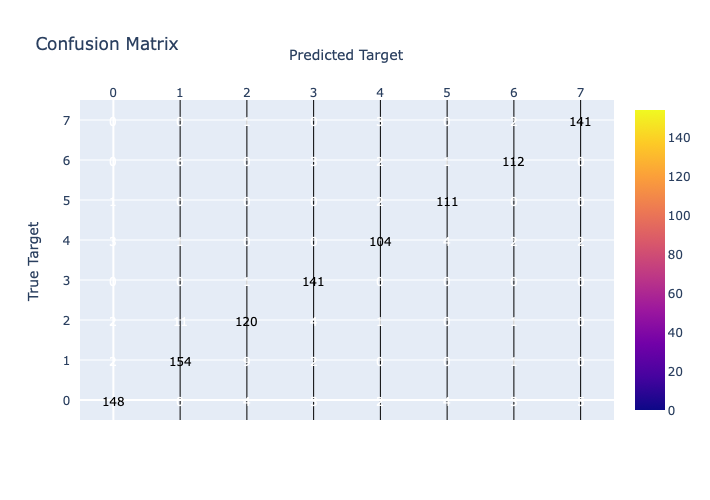

In [23]:
# annotated
import plotly.figure_factory as ff
y_pred = Pickled_MLP_Model.predict(X_test)
df_cm = pd.DataFrame(confusion_matrix(y_test,  y_pred))
fig = ff.create_annotated_heatmap(df_cm.values, colorscale="Plasma",showscale=True,x=df_cm.columns.to_list(),y=df_cm.index.to_list())
fig.update_layout(title='Confusion Matrix',width = 500, height = 500,xaxis_title='Predicted Target',yaxis_title='True Target')
fig.show()

Auc_Roc Curve

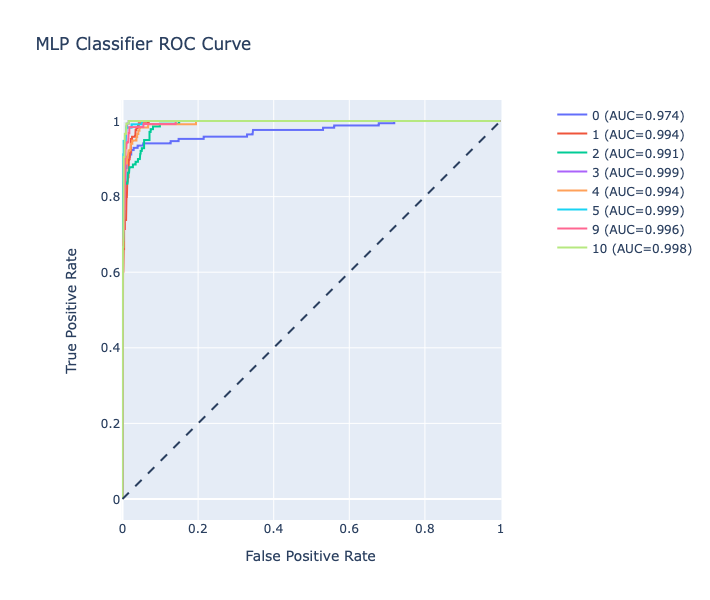

In [24]:
Multiple_ROC_Curve(X_test,y_test,Pickled_MLP_Model,chart_title='MLP Classifier ROC Curve')

Accuracy

In [26]:
Accuracy(Pickled_MLP_Model)

0.9214

# <a id='toc7_'></a>[7 Implementation on new news data](#toc0_)

This section shows how to predict news articles using saved model

Load 100 sample news articles

In [27]:
news = pd.read_excel('/News_NLP/data/SampleNews.xlsx').iloc[:100,]

Exmaple to merge `title`,`description`,`content`.

Prior to merging, please ensure  `title` and `content` are not empty

In [28]:
def covert_nan(x):
    
    if pd.isna(x):
        return ""
    else:
        return str(x)
    
def Combine_Col(dataset, col_1, col_2):
    
    df_col_1_2 = pd.DataFrame(dataset[col_1]+ '. ' + dataset[col_2].map(covert_nan),columns=[col_1+'_'+col_2])
    new_dataset = pd.concat([df_col_1_2,dataset],axis=1)
    
    return new_dataset

# data is a dataframe  of news
news= Combine_Col(news,'title','description')
news= Combine_Col(news,'title_description','content')
news.drop(['title_description'],axis=1, inplace = True)

In [29]:
news.head(1)

title_description_content  \
0  War Crimes Hearing Revisits U.S. Soldiers’ Abu...   

                                news_id     source_name           author  \
0  1e1e36a8-d379-4d96-a23a-65c9cc925ab6  New York Times  Carol Rosenberg   

                                               title  \
0  War Crimes Hearing Revisits U.S. Soldiers’ Abu...   

                                             content  \
0  At one point, a military prosecutor suggested ...   

                                         description           publishedAt  \
0  An Army judge is hearing pretrial testimony to...  2022-05-01T16:03:45Z   

  search_term                                                url  
0         war  https://www.nytimes.com/2022/05/01/us/politics...

Clean news data

In [30]:
%%time
news['TDC'] = news['title_description_content'].apply(lambda x : Preprocessing_Clf_SA(x))

CPU times: user 211 ms, sys: 0 ns, total: 211 ms
Wall time: 210 ms


In [31]:
news.shape

(100, 11)

In [32]:
news.isnull().sum()

title_description_content     0
news_id                       0
source_name                   0
author                       19
title                         0
content                       0
description                   1
publishedAt                   0
search_term                   0
url                           0
TDC                           0
dtype: int64

In [33]:
# drop empty rows
news= news.query('TDC == TDC')

In [34]:
news.shape

(100, 11)

Set max_features

In [36]:
Max_Features=5400

TFIDF Vectorization

In [38]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
# create the transformation matrix
vectorizer = TfidfVectorizer(max_features=Max_Features)
# tokenize and build vocabularies
vectorizer_idf= vectorizer.fit(df_train['TDC'])
# vectorizer.vocabulary_
# vectorizer.idf_
X_train  = vectorizer_idf.transform(df_train['TDC']).toarray()
news_array  = vectorizer_idf.transform(news['TDC']).toarray()


CPU times: user 2.69 s, sys: 55.7 ms, total: 2.74 s
Wall time: 2.74 s


Predict 

In [39]:
df_pred = pd.DataFrame(Pickled_MLP_Model.predict(news_array),columns=['pred_class'])

Predicted class code

In [40]:
df_pred.pred_class.unique()

array([ 2,  1,  4,  0,  9, 10,  3])

In [41]:
news= pd.concat([news, df_pred],axis=1)

In [42]:
news.head(2)

title_description_content  \
0  War Crimes Hearing Revisits U.S. Soldiers’ Abu...   
1  Ukraine round-up: Mariupol evacuation and pilo...   

                                news_id     source_name  \
0  1e1e36a8-d379-4d96-a23a-65c9cc925ab6  New York Times   
1  8313a259-89aa-461c-b978-7b75ea187a9b        BBC News   

                             author  \
0                   Carol Rosenberg   
1  https://www.facebook.com/bbcnews   

                                               title  \
0  War Crimes Hearing Revisits U.S. Soldiers’ Abu...   
1  Ukraine round-up: Mariupol evacuation and pilo...   

                                             content  \
0  At one point, a military prosecutor suggested ...   
1  Image caption, Evacuees at Russia's Bezimenne ...   

                                         description           publishedAt  \
0  An Army judge is hearing pretrial testimony to...  2022-05-01T16:03:45Z   
1  The Red Cross and UN say they are evacuating c...  2022-05-01T20:10:02Z   

  search_term                                                url  \
0         war  https://www.nytimes.com/2022/05/01/us/politics...   
1         war   https://www.bbc.co.uk/news/world-europe-61292248   

                                                 TDC  pred_class  
0  war crimes hearing revisits abuse detainees ar...           2  
1  ukraine roundup mariupol evacuation pilot lege...           1

Prediction probabilities

In [44]:
pred_prob = Pickled_MLP_Model.predict_proba(news_array)
pred_prob = pd.DataFrame(pred_prob).round(3)
# pred_prob.index = news.index
df_true_pred_prob = pd.concat([df_pred,pred_prob],axis=1)

Prediction probabilities

Rename class code to inline with the database topics code

In [45]:
df_true_pred_prob.rename(columns={6:9,7:10},inplace=True)

In [46]:
df_true_pred_prob

pred_class      0      1      2      3      4      5      9     10
0            2  0.039  0.011  0.687  0.257  0.002  0.001  0.003  0.001
1            1  0.085  0.864  0.035  0.001  0.002  0.000  0.012  0.002
2            1  0.236  0.709  0.040  0.001  0.003  0.001  0.008  0.003
3            4  0.032  0.038  0.028  0.012  0.477  0.044  0.364  0.005
4            1  0.017  0.866  0.064  0.000  0.000  0.000  0.052  0.001
..         ...    ...    ...    ...    ...    ...    ...    ...    ...
95           1  0.044  0.782  0.105  0.004  0.001  0.001  0.062  0.001
96           0  0.935  0.006  0.011  0.002  0.015  0.012  0.005  0.014
97           0  0.988  0.002  0.001  0.001  0.002  0.007  0.000  0.000
98           0  0.312  0.008  0.224  0.117  0.043  0.019  0.267  0.010
99           3  0.113  0.001  0.019  0.798  0.031  0.025  0.003  0.011

[100 rows x 9 columns]

Query geopolitical risk news

In [47]:
gpr_news = news.query('pred_class != 0')

In [48]:
gpr_news.shape

(53, 12)

In [49]:
gpr_news.head(1)

title_description_content  \
0  War Crimes Hearing Revisits U.S. Soldiers’ Abu...   

                                news_id     source_name           author  \
0  1e1e36a8-d379-4d96-a23a-65c9cc925ab6  New York Times  Carol Rosenberg   

                                               title  \
0  War Crimes Hearing Revisits U.S. Soldiers’ Abu...   

                                             content  \
0  At one point, a military prosecutor suggested ...   

                                         description           publishedAt  \
0  An Army judge is hearing pretrial testimony to...  2022-05-01T16:03:45Z   

  search_term                                                url  \
0         war  https://www.nytimes.com/2022/05/01/us/politics...   

                                                 TDC  pred_class  
0  war crimes hearing revisits abuse detainees ar...           2